In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [2]:
def read_rewards(filepath):
    x = []
    with open(filepath, "rb") as openfile:
        while True:
            try:
                x.append(pickle.load(openfile))
            except EOFError:
                break
    return x

In [3]:
def _plot_for_appendix(ax, exp_name, _legends='Walker 1', nb_version=10,
                       _type='mix', ylim=True, nb_walker=1,
                       legend=False, stop_th=10000, loc=(.70, 1.1), team=False,
                       yticks=None, xticks=None, _mod=1):
    eval_reward_p = 'evaluation_rewards'
    epis_reward_p = 'episodic_rewards'
    # all_times_p = 'all_times'

    r_episodic_s = []
    r_eval_s = []
    # times = []

    for seed in range(0, nb_version):

        epis_filepath = f'{exp_name}/{epis_reward_p}/seed_{seed}.pkl'
        eval_filepath = f'{exp_name}/{eval_reward_p}/seed_{seed}.pkl'
        # all_times_filepath = f'{exp_name}/{all_times_p}/seed_{seed}.pkl'

        if 'facmac' in epis_filepath:
            r_episodic = read_rewards(epis_filepath)[::_mod]
            r_e = read_rewards(eval_filepath)
            r_eval = r_e[::_mod]
            r_eval.append(r_e[-1])
        else:
            r_episodic = read_rewards(epis_filepath)[0][::_mod]
            r_eval = read_rewards(eval_filepath)[0][::_mod]
        r_episodic = [i for item in r_episodic for i in item]
        r_episodic_s.append(r_episodic)
        r_eval_s.append(r_eval)

    evaluation_rewards = np.array(r_eval_s)
    if (_type == 'CDDPG' or _type == 'CQF') and nb_walker == 1:
        evaluation_rewards /= 2
        evaluation_rewards = np.concatenate((evaluation_rewards, evaluation_rewards), axis=2)
    eval_team = np.zeros((evaluation_rewards.shape[0], evaluation_rewards.shape[1]))
    for i in range(0, np.array(evaluation_rewards).shape[2], 2):
        eval_team += evaluation_rewards[:, :, i]

    _r = np.concatenate((np.mean(evaluation_rewards, axis=0), np.mean(eval_team, axis=0)[None].T), axis=1)

    _r_stds = np.concatenate((np.std(evaluation_rewards, axis=0), np.std(eval_team, axis=0)[None].T), axis=1)

    xs = [i * stop_th * _mod for i in range(_r.shape[0])]

    if team:
        # one leg is enough for that walkers reward:
        _r = _r[:, [0, 2, 4]]
        _r_stds = _r_stds[:, [0, 2, 4]]
        if legend:
            lines = ax.plot(xs, _r, label=_legends)
            lines[-1].set_color('green')
            leg = axes[0][0].legend(shadow=False, fancybox=True, loc=loc, ncol=6)
            for line in leg.get_lines():
                line.set_linewidth(10.0)

        else:
            lines = ax.plot(xs, _r)
            lines[-1].set_color('green')

        # xs = list(range(_r.shape[0]))
        for i in range(_r.shape[1]):
            ax.fill_between(xs,
                            (_r - (_r_stds * 1.96) / np.sqrt(nb_version))[:, i],
                            (_r + (_r_stds * 1.96) / np.sqrt(nb_version))[:, i],
                            color=lines[i].get_color(), alpha=0.2)

    else:
        i = -1
        if nb_walker == 1:
            color = 'red'
        else:
            color = 'green'
        if legend:
            lines = ax.plot(xs, _r[:, i], label=_legends)
            lines[-1].set_color(color)
            leg = axes[0][0].legend(shadow=False, fancybox=True, loc=loc, ncol=6)
            for line in leg.get_lines():
                line.set_linewidth(10.0)

        else:
            lines = ax.plot(xs, _r[:, i])
            lines[-1].set_color(color)
        # xs = list(range(_r.shape[0]))

        ax.fill_between(xs,
                        (_r - (_r_stds * 1.96) / np.sqrt(nb_version))[:, i],
                        (_r + (_r_stds * 1.96) / np.sqrt(nb_version))[:, i],
                        color=lines[i].get_color(), alpha=0.2)

    print(_type, _r[-1])

    ax.set_ylabel('Average Reward')
    ax.set_xlabel('Step #')
    # ax.legend(_legends, loc='lower right')
    ax.title.set_text(f'{_type}')
    if yticks:
        ax.set_yticks(yticks)
    if xticks:
        ax.set_xticks(xticks)

    if ylim:
        ax.set_ylim(ymin=-150, ymax=150)


CQF [29.0639823 29.0639823 29.0639823]
IQF [80.72343053 80.72343053 80.72343053]
CDDPG [-0.13203838 -0.13203838 -0.13203838]
IDDPG [5.04437128 5.04437128 5.04437128]
MADDPG-TEAM [-20.23079897 -20.23079897 -20.23079897]
MADDPG-IND [-59.0551419 -59.0551419 -59.0551419]
FACMAC [74.42173538 74.42173538 74.42173538]
MQF [93.29750252 93.29750252 93.29750252]


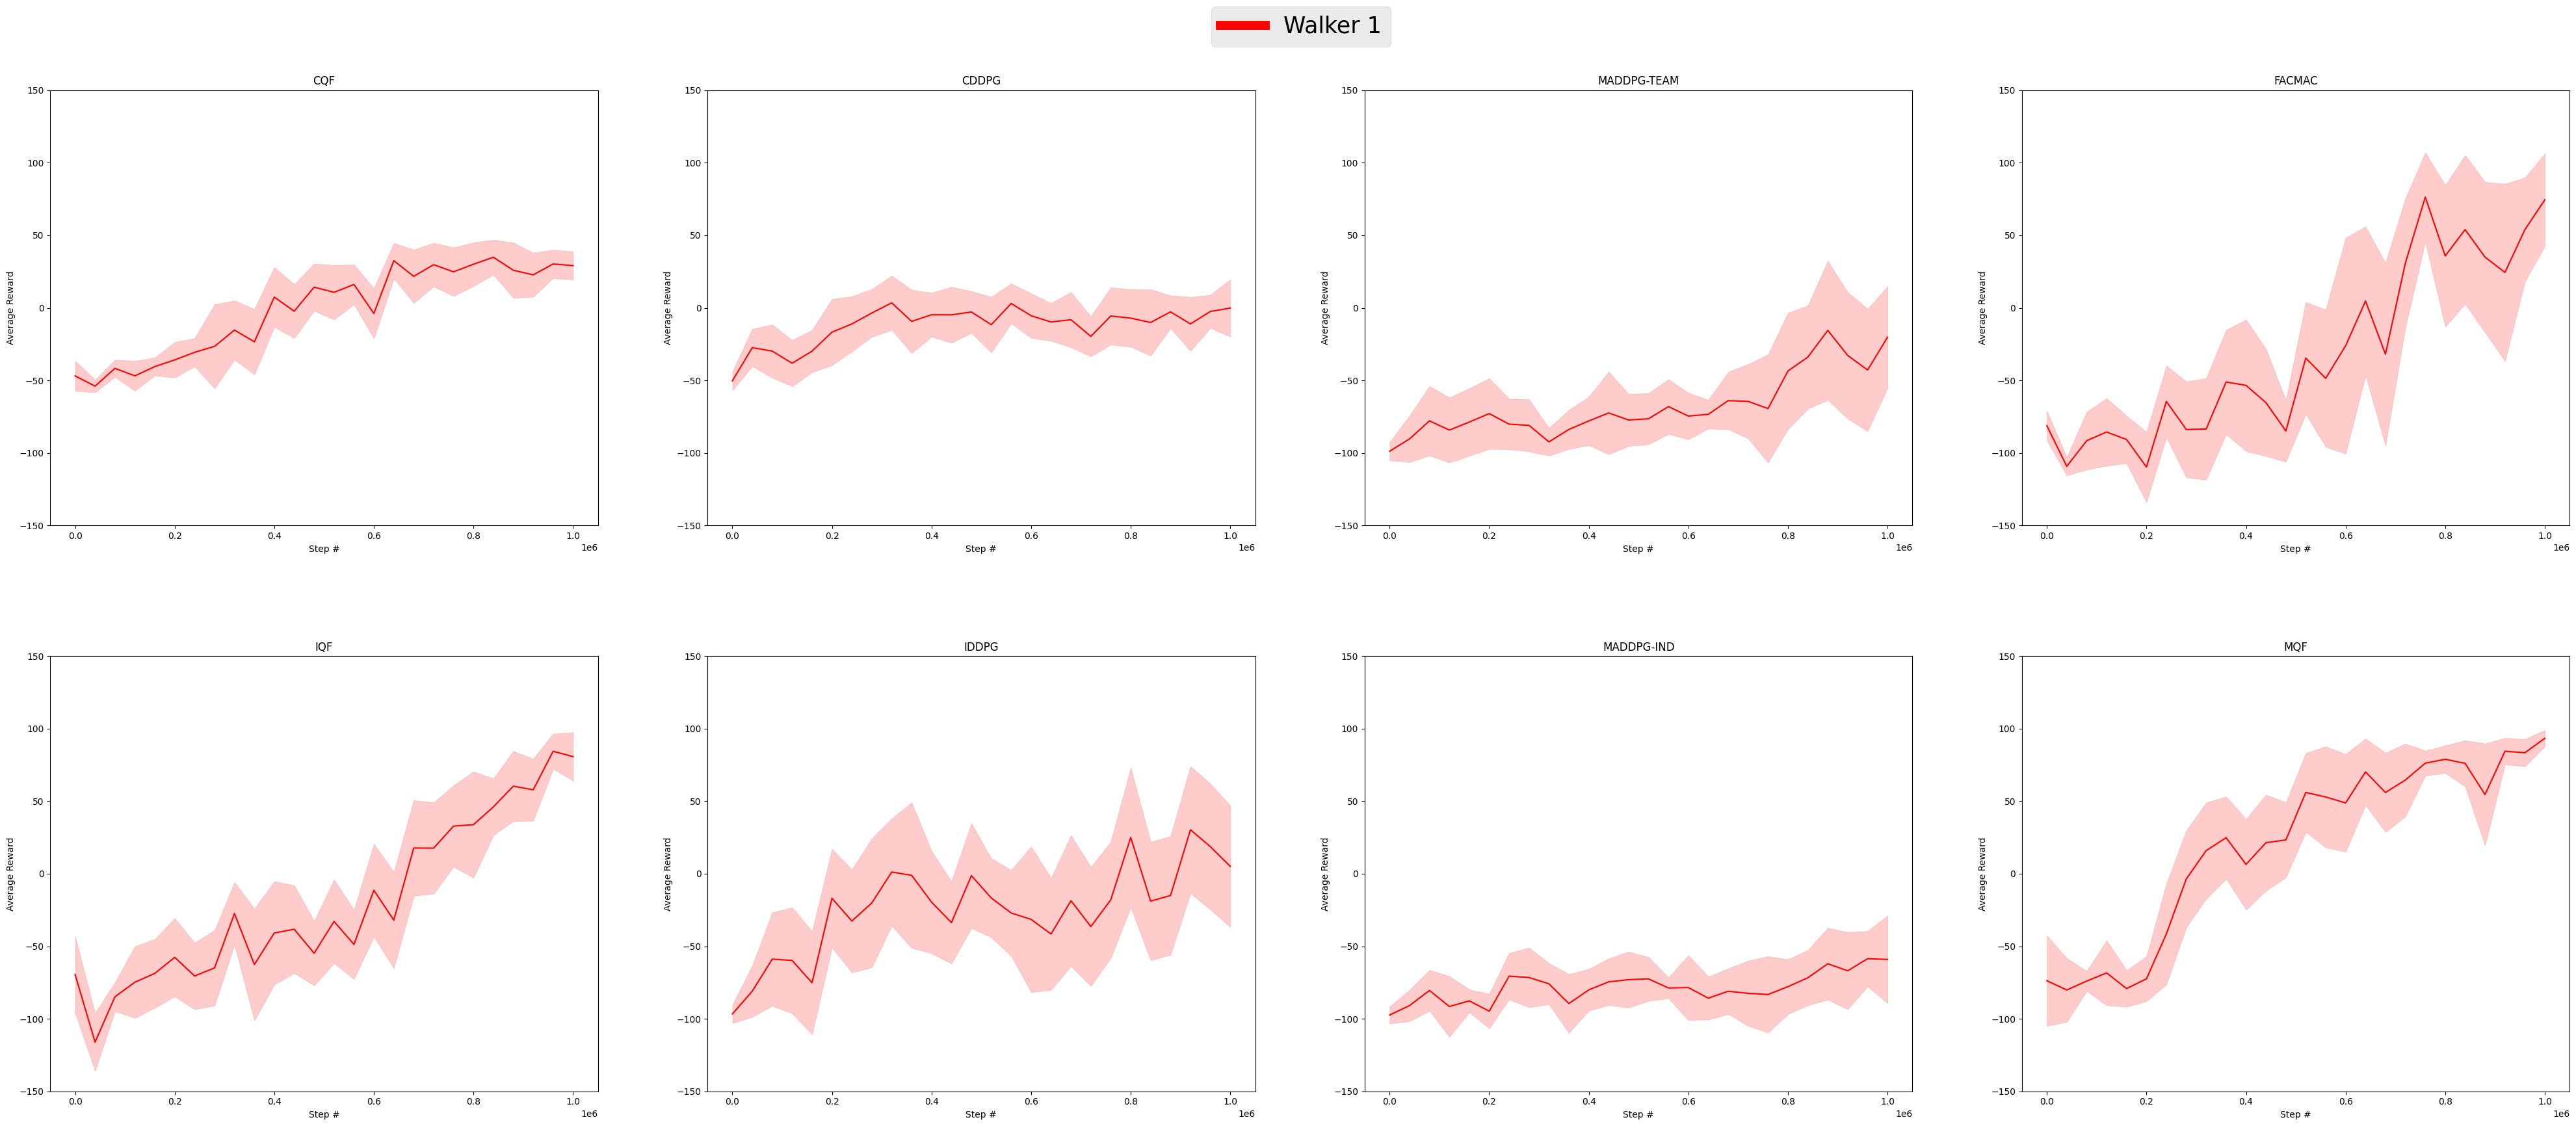

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(50, 20))

plt.subplots_adjust(hspace=0.3)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 25})

mix_keyword = 'mix_sum_run_50-step-update_nb-walkers-1_terrain-length-30_forward-reward-5_me-len-500_func-polynomial_rank-2_episode-20000_lr0001_b512_l2_g099_n256_m500000'
ind_keyword = 'ind_run_50-step-update_nb-walkers-1_terrain-length-30_forward-reward-5_me-len-500_func-polynomial_rank-2_episode-20000_lr0001_b512_l2_g099_n256_m500000'
cent_keyword = 'centralized_run_50-step-update_nb-walkers-1_terrain-length-30_forward-reward-5_me-len-500_func-polynomial_rank-2_episode-20000_lr0001_b512_l2_g099_n256_m500000'
maddpg_keyword_50 = 'maddpg_run_50-step-update_r_type_nb-walkers-1_terrain-length-30_forward-reward-5_me-len-500_episode-20000_lr0001_tlr001_b512_l2_g099_n256_m500000'
cddpg_keyword_10 = 'cddpg_run_10-step-update_nb-walkers-1_terrain-length-30_forward-reward-5_me-len-500_episode-20000_lr25e-05_b512_l2_g099_n256_m500000'
iddpg_keyword_10 = 'iddpg_run_10-step-update_nb-walkers-1_terrain-length-30_forward-reward-5_me-len-500_episode-20000_lr25e-05_b512_l2_g099_n256_m500000'
facmac = 'facmac_run_2-nb-update_nb-walkers-1_terrain-length-30_forward-reward-5_me-len-500_episode-20000_lr001_b512_l3_g099_n256_m500000'

nb_version = 10
_mod = 4

_plot_for_appendix(axes[0][0], cent_keyword, legend=True, _mod=_mod,
                   nb_version=nb_version, _type='CQF', loc=(2.12, 1.1))

_plot_for_appendix(axes[1][0], ind_keyword, _mod=_mod,
                   nb_version=nb_version, _type='IQF')

_plot_for_appendix(axes[0][1], cddpg_keyword_10,
                   nb_version=nb_version, _type='CDDPG', _mod=_mod)

_plot_for_appendix(axes[1][1], iddpg_keyword_10,
                   nb_version=nb_version, _type='IDDPG', _mod=_mod)

_plot_for_appendix(axes[0][2], maddpg_keyword_50.replace('r_type', 'team-reward'),
                   nb_version=nb_version, _type='MADDPG-TEAM', _mod=_mod)

_plot_for_appendix(axes[1][2], maddpg_keyword_50.replace('r_type', 'individual-reward'),
                   nb_version=nb_version, _type='MADDPG-IND', _mod=_mod)

_plot_for_appendix(axes[0][3], facmac, _mod=_mod,
                   nb_version=nb_version, _type='FACMAC')

_plot_for_appendix(axes[1][3], mix_keyword, _mod=_mod,
                   nb_version=nb_version, _type='MQF', yticks=[-150, -100, -50, 0, 50, 100, 150])


In [47]:
fig.savefig('2a1w_appendix_neurips.svg')